In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import numpy as np
from matplotlib import pyplot as plt
from regularization_helper import plot_it, get_simple_dataset, get_polynimial_set, plot_classifier, save_dataset
from sklearn import model_selection
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import optimizers
from fnn_helper import PlotLosses
from keras.callbacks import ModelCheckpoint 
from keras import regularizers

## Cargo y ploteo dataset

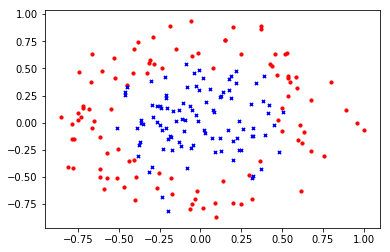

In [125]:
dataset_200 = np.load('200_samples_OK.npy')
X = dataset_200[:,:2]
y = dataset_200[:, 2]
plot_it(X,y)
plt.show()

## Defino el modelo

In [88]:
def get_two_layer_model_fixed():
    input_shape=2
    output_size=1
    hidden_units= 10
    lr=2
    decay=0.0
    model = Sequential()
    sgd = optimizers.SGD(lr=lr, decay=decay)
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', ))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

# K-fold Cross Validation
- No tengo un dataset grande
- Pros: Ayuda a validar mejor el modelo
- Cons: Puede llevar tiempo
- Podriamos haber separado el test set y trabajar con el training set para dividirlo

In [89]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(10)

In [90]:
i=0
training_sets = []
for train_index, test_index in skf.split(X, y):
    i=i+1
    print("CV dataset:", i)
    print(train_index.shape, test_index.shape)
    dictionary = {'X_train':X[train_index], 'y_train':y[train_index], 'X_test':X[test_index],'y_test':y[test_index]}
    training_sets.append(dictionary)

CV dataset: 1
(180,) (20,)
CV dataset: 2
(180,) (20,)
CV dataset: 3
(180,) (20,)
CV dataset: 4
(180,) (20,)
CV dataset: 5
(180,) (20,)
CV dataset: 6
(180,) (20,)
CV dataset: 7
(180,) (20,)
CV dataset: 8
(180,) (20,)
CV dataset: 9
(180,) (20,)
CV dataset: 10
(180,) (20,)


## Grafico uno de los train/test sets

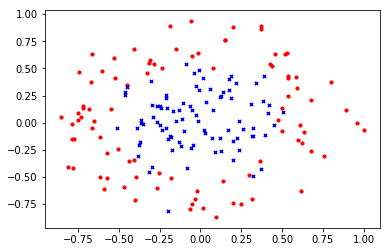

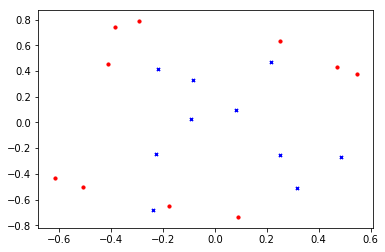

In [128]:
idx = 1
plot_it(training_sets[idx]['X_train'],training_sets[idx]['y_train'])
plt.show()
plot_it(training_sets[idx]['X_test'],training_sets[idx]['y_test'])
plt.show()

## Entreno de manera tradicional uno de los k-folds

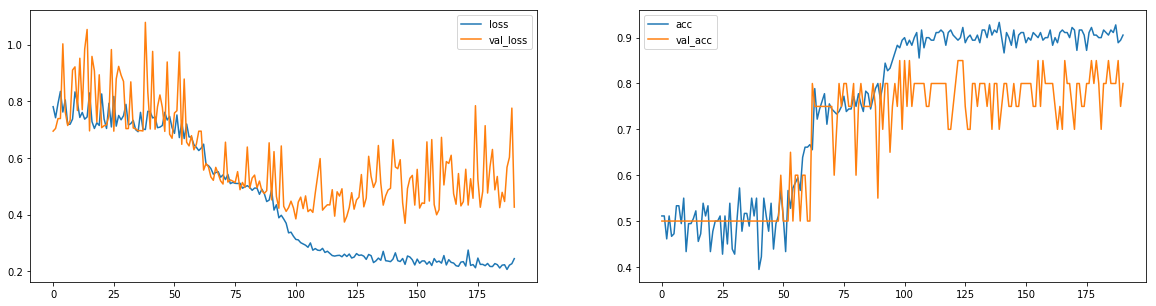

In [95]:
idx = 1
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None, x_val=training_sets[idx]['X_test'], y_val_categorical=training_sets[idx]['y_test'])

two_layer_model = get_two_layer_model_fixed()
two_layer_model.fit(training_sets[idx]['X_train'], 
          training_sets[idx]['y_train'], batch_size = 25,
          epochs=200, 
          verbose=0, 
          validation_data=(training_sets[idx]['X_test'], training_sets[idx]['y_test']), 
          callbacks=[plot_losses],
         )

## Entreno usando cross_val_scores de SciKitLearn

In [96]:
from sklearn.model_selection import cross_val_score
# cross_val_score(classifier, X, y, cv, n_jobs=)
# El problema es que el 'classifier' es de sklearn y tenemos uno de Keras
# Por lo tanto hay que utilizar un wrapper
from keras.wrappers.scikit_learn import KerasClassifier

In [97]:
classifier = KerasClassifier(get_two_layer_model_fixed, batch_size=25,  
                             epochs=100, verbose=0)
cross_val_scores = cross_val_score(estimator=classifier, X=X, y=y, cv=skf, 
                                   scoring='accuracy') # n_jobs=-1

In [98]:
cross_val_scores

array([ 0.9 ,  0.9 ,  0.9 ,  0.85,  0.95,  0.9 ,  1.  ,  0.8 ,  0.85,  0.9 ])

In [99]:
cross_val_scores.mean(), cross_val_scores.std()

(0.89500000000000013, 0.052201532544552745)

- low, high accuracy and low, high variance
- high variance --> overfitting

# Ajuste de Hyperparametros (Parameter tunning)

In [113]:
from sklearn.model_selection import GridSearchCV

In [115]:
def get_two_layer_model_variable(lr, hidden_units):
    input_shape=2
    output_size=1
    optimizer = optimizers.SGD(lr=lr, decay=0.0)
    model = Sequential()
    model.add(Dense(hidden_units,input_dim=input_shape,  activation='sigmoid', ))
    model.add(Dense(output_size, 
                    activation='sigmoid', 
                    kernel_initializer='zeros', 
                    name='Salida'
                   ))
    model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
classifier_variable = KerasClassifier(build_fn=get_two_layer_model_variable, epochs=100, verbose=0)

In [116]:
#sgd = optimizers.SGD(lr=2, decay=0.0)
parameters = {
    'batch_size': [25,100], 
    'lr': [2,1],
    'hidden_units': [3,10]
             }

In [117]:
grid_search = GridSearchCV(estimator=classifier_variable, cv=skf, param_grid=parameters, scoring='accuracy')

In [119]:
grid_search.fit(X=X, y=y, verbose=1)

Epoch 1/100
180/180 [==============================] - 3s - loss: 0.7148 - acc: 0.4222      
Epoch 2/100
180/180 [==============================] - 0s - loss: 0.6982 - acc: 0.4889     
Epoch 3/100
180/180 [==============================] - 0s - loss: 0.7528 - acc: 0.4722     
Epoch 4/100
180/180 [==============================] - 0s - loss: 0.7797 - acc: 0.4722     
Epoch 5/100
180/180 [==============================] - 0s - loss: 0.7067 - acc: 0.4889     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.7194 - acc: 0.5056     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.7521 - acc: 0.4389     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.7194 - acc: 0.4500     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.7768 - acc: 0.3833     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.7146 - acc: 0.4778     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.7259 - ac

180/180 [==============================] - 0s - loss: 0.5790 - acc: 0.7222     
Epoch 76/100
180/180 [==============================] - 0s - loss: 0.5618 - acc: 0.7111     
Epoch 77/100
180/180 [==============================] - 0s - loss: 0.5502 - acc: 0.7278     
Epoch 78/100
180/180 [==============================] - 0s - loss: 0.5343 - acc: 0.7167     
Epoch 79/100
180/180 [==============================] - 0s - loss: 0.5606 - acc: 0.7222     
Epoch 80/100
180/180 [==============================] - 0s - loss: 0.5047 - acc: 0.7722     
Epoch 81/100
180/180 [==============================] - 0s - loss: 0.5240 - acc: 0.7333     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.5045 - acc: 0.7667     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.5176 - acc: 0.7222     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.4823 - acc: 0.7722     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.4591 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6982 - acc: 0.5056     
Epoch 50/100
180/180 [==============================] - 0s - loss: 0.6982 - acc: 0.4889     
Epoch 51/100
180/180 [==============================] - 0s - loss: 0.7139 - acc: 0.4944     
Epoch 52/100
180/180 [==============================] - 0s - loss: 0.7040 - acc: 0.4556     
Epoch 53/100
180/180 [==============================] - 0s - loss: 0.6969 - acc: 0.4611     
Epoch 54/100
180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.5111     
Epoch 55/100
180/180 [==============================] - 0s - loss: 0.6957 - acc: 0.5556     
Epoch 56/100
180/180 [==============================] - 0s - loss: 0.7054 - acc: 0.5389     
Epoch 57/100
180/180 [==============================] - 0s - loss: 0.6934 - acc: 0.5278     
Epoch 58/100
180/180 [==============================] - 0s - loss: 0.6911 - acc: 0.5500     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.6883 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7134 - acc: 0.4889     
Epoch 25/100
180/180 [==============================] - 0s - loss: 0.6966 - acc: 0.5278     
Epoch 26/100
180/180 [==============================] - 0s - loss: 0.7503 - acc: 0.4833     
Epoch 27/100
180/180 [==============================] - 0s - loss: 0.7061 - acc: 0.5278     
Epoch 28/100
180/180 [==============================] - 0s - loss: 0.7654 - acc: 0.4222     
Epoch 29/100
180/180 [==============================] - 0s - loss: 0.7297 - acc: 0.4611     
Epoch 30/100
180/180 [==============================] - 0s - loss: 0.7054 - acc: 0.5000     
Epoch 31/100
180/180 [==============================] - 0s - loss: 0.7005 - acc: 0.4889     
Epoch 32/100
180/180 [==============================] - 0s - loss: 0.7047 - acc: 0.4889     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.7152 - acc: 0.5167     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.6942 - acc: 0.

180/180 [==============================] - 0s - loss: 0.4962 - acc: 0.7833     
Epoch 1/100
180/180 [==============================] - 3s - loss: 0.7011 - acc: 0.5500      
Epoch 2/100
180/180 [==============================] - 0s - loss: 0.6947 - acc: 0.5444     
Epoch 3/100
180/180 [==============================] - 0s - loss: 0.7102 - acc: 0.6000     
Epoch 4/100
180/180 [==============================] - 0s - loss: 0.7424 - acc: 0.4111     
Epoch 5/100
180/180 [==============================] - 0s - loss: 0.6949 - acc: 0.5500     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.7094 - acc: 0.4833     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.6938 - acc: 0.5611     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.6997 - acc: 0.5167     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.7291 - acc: 0.4444     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.7146 - acc: 0.4722    

180/180 [==============================] - 0s - loss: 0.7044 - acc: 0.4833     
Epoch 77/100
180/180 [==============================] - 0s - loss: 0.6723 - acc: 0.5444     
Epoch 78/100
180/180 [==============================] - 0s - loss: 0.6783 - acc: 0.5444     
Epoch 79/100
180/180 [==============================] - 0s - loss: 0.7068 - acc: 0.5167     
Epoch 80/100
180/180 [==============================] - 0s - loss: 0.6802 - acc: 0.5222     
Epoch 81/100
180/180 [==============================] - 0s - loss: 0.6749 - acc: 0.4667     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.6825 - acc: 0.5778     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.6569 - acc: 0.6000     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.6556 - acc: 0.6333     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.6391 - acc: 0.6167     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.6315 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6963 - acc: 0.5222     
Epoch 52/100
180/180 [==============================] - 0s - loss: 0.7060 - acc: 0.5167     
Epoch 53/100
180/180 [==============================] - 0s - loss: 0.6981 - acc: 0.4444     
Epoch 54/100
180/180 [==============================] - 0s - loss: 0.6991 - acc: 0.5500     
Epoch 55/100
180/180 [==============================] - 0s - loss: 0.7035 - acc: 0.5056     
Epoch 56/100
180/180 [==============================] - 0s - loss: 0.6977 - acc: 0.5389     
Epoch 57/100
180/180 [==============================] - 0s - loss: 0.7076 - acc: 0.4722     
Epoch 58/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.5056     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.7039 - acc: 0.5611     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.7025 - acc: 0.4389     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.6933 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.5333     
Epoch 27/100
180/180 [==============================] - 0s - loss: 0.7114 - acc: 0.5278     
Epoch 28/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.5667     
Epoch 29/100
180/180 [==============================] - 0s - loss: 0.6904 - acc: 0.5778     
Epoch 30/100
180/180 [==============================] - 0s - loss: 0.6949 - acc: 0.5444     
Epoch 31/100
180/180 [==============================] - 0s - loss: 0.6988 - acc: 0.5556     
Epoch 32/100
180/180 [==============================] - 0s - loss: 0.7174 - acc: 0.4833     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.6881 - acc: 0.5778     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.7049 - acc: 0.4500     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.6876 - acc: 0.5056     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.7055 - acc: 0.

180/180 [==============================] - 3s - loss: 0.6960 - acc: 0.4944      
Epoch 2/100
180/180 [==============================] - 0s - loss: 0.7023 - acc: 0.4500     
Epoch 3/100
180/180 [==============================] - 0s - loss: 0.7062 - acc: 0.4778     
Epoch 4/100
180/180 [==============================] - 0s - loss: 0.6975 - acc: 0.4944     
Epoch 5/100
180/180 [==============================] - 0s - loss: 0.7005 - acc: 0.4944     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.7122 - acc: 0.4778     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.7248 - acc: 0.4278     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.7016 - acc: 0.4667     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.7028 - acc: 0.4722     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.7061 - acc: 0.4389     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.7032 - acc: 0.4889   

180/180 [==============================] - 0s - loss: 0.6913 - acc: 0.5667     
Epoch 78/100
180/180 [==============================] - 0s - loss: 0.6888 - acc: 0.5444     
Epoch 79/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.5167     
Epoch 80/100
180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.5167     
Epoch 81/100
180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.4556     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.6844 - acc: 0.5556     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.6981 - acc: 0.4833     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.6866 - acc: 0.5167     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.6788 - acc: 0.5389     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.6841 - acc: 0.5667     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.6915 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.5389     
Epoch 54/100
180/180 [==============================] - 0s - loss: 0.7026 - acc: 0.4889     
Epoch 55/100
180/180 [==============================] - 0s - loss: 0.6955 - acc: 0.5056     
Epoch 56/100
180/180 [==============================] - 0s - loss: 0.7006 - acc: 0.4667     
Epoch 57/100
180/180 [==============================] - 0s - loss: 0.6899 - acc: 0.4944     
Epoch 58/100
180/180 [==============================] - 0s - loss: 0.6911 - acc: 0.4722     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.6984 - acc: 0.5167     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.6958 - acc: 0.5222     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.6888 - acc: 0.5556     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.6894 - acc: 0.5556     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.6876 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6994 - acc: 0.5056     
Epoch 30/100
180/180 [==============================] - 0s - loss: 0.6938 - acc: 0.5056     
Epoch 31/100
180/180 [==============================] - 0s - loss: 0.6999 - acc: 0.5000     
Epoch 32/100
180/180 [==============================] - 0s - loss: 0.7079 - acc: 0.4278     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.6969 - acc: 0.4889     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.6945 - acc: 0.5167     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.7028 - acc: 0.4889     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.7017 - acc: 0.4833     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.7025 - acc: 0.5222     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.7031 - acc: 0.4833     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.6990 - acc: 0.

180/180 [==============================] - 0s - loss: 0.8512 - acc: 0.4667     
Epoch 5/100
180/180 [==============================] - 0s - loss: 0.7115 - acc: 0.5111     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.8573 - acc: 0.4556     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.8432 - acc: 0.4611     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.8495 - acc: 0.5000     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.9689 - acc: 0.4667     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.6962 - acc: 0.5444     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.8517 - acc: 0.4333     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.9213 - acc: 0.4889     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.8570 - acc: 0.4111     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.7392 - acc: 0.4778 

180/180 [==============================] - 0s - loss: 0.4594 - acc: 0.8056     
Epoch 81/100
180/180 [==============================] - 0s - loss: 0.4476 - acc: 0.8056     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.4521 - acc: 0.7556     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.4191 - acc: 0.8056     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.4872 - acc: 0.7556     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.4067 - acc: 0.8056     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.3974 - acc: 0.8167     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.4083 - acc: 0.8111     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.3666 - acc: 0.8556     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.3503 - acc: 0.8722     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.3955 - acc: 0.

180/180 [==============================] - 0s - loss: 0.5786 - acc: 0.7444     
Epoch 57/100
180/180 [==============================] - 0s - loss: 0.5292 - acc: 0.8056     
Epoch 58/100
180/180 [==============================] - 0s - loss: 0.5080 - acc: 0.7944     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.5195 - acc: 0.7611     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.5108 - acc: 0.8000     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.4616 - acc: 0.8278     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.4445 - acc: 0.8333     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.4494 - acc: 0.8056     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.4341 - acc: 0.8389     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.4309 - acc: 0.8278     
Epoch 66/100
180/180 [==============================] - 0s - loss: 0.3986 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7137 - acc: 0.5000     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.7336 - acc: 0.4111     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.7892 - acc: 0.5500     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.6987 - acc: 0.5444     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.7096 - acc: 0.5667     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.7334 - acc: 0.4778     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.7316 - acc: 0.5056     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.7046 - acc: 0.5333     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.7250 - acc: 0.5056     
Epoch 41/100
180/180 [==============================] - 0s - loss: 0.6872 - acc: 0.5333     
Epoch 42/100
180/180 [==============================] - 0s - loss: 0.6953 - acc: 0.

180/180 [==============================] - 0s - loss: 0.9238 - acc: 0.4722     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.7570 - acc: 0.4833     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.8308 - acc: 0.5000     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.6949 - acc: 0.5389     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.7367 - acc: 0.5889     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.7943 - acc: 0.4611     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.8091 - acc: 0.5000     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.8070 - acc: 0.4944     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.9436 - acc: 0.4167     
Epoch 16/100
180/180 [==============================] - 0s - loss: 0.7495 - acc: 0.5278     
Epoch 17/100
180/180 [==============================] - 0s - loss: 0.7538 - acc: 0.49

180/180 [==============================] - 0s - loss: 0.3469 - acc: 0.8778     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.3575 - acc: 0.8778     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.3602 - acc: 0.8389     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.3241 - acc: 0.8778     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.3790 - acc: 0.8389     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.3438 - acc: 0.8778     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.3844 - acc: 0.8500     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.3043 - acc: 0.9056     
Epoch 91/100
180/180 [==============================] - 0s - loss: 0.3050 - acc: 0.8944     
Epoch 92/100
180/180 [==============================] - 0s - loss: 0.3183 - acc: 0.8889     
Epoch 93/100
180/180 [==============================] - 0s - loss: 0.3033 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7102 - acc: 0.5111     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.7193 - acc: 0.4056     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.6965 - acc: 0.5111     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.7013 - acc: 0.4833     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.7185 - acc: 0.5056     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.7185 - acc: 0.4889     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.7109 - acc: 0.4667     
Epoch 66/100
180/180 [==============================] - 0s - loss: 0.6951 - acc: 0.5222     
Epoch 67/100
180/180 [==============================] - 0s - loss: 0.7176 - acc: 0.4833     
Epoch 68/100
180/180 [==============================] - 0s - loss: 0.7006 - acc: 0.4944     
Epoch 69/100
180/180 [==============================] - 0s - loss: 0.7037 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7396 - acc: 0.4833     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.7028 - acc: 0.5111     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.7019 - acc: 0.4833     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.6997 - acc: 0.5222     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.6950 - acc: 0.5222     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.7198 - acc: 0.5222     
Epoch 41/100
180/180 [==============================] - 0s - loss: 0.7187 - acc: 0.4611     
Epoch 42/100
180/180 [==============================] - 0s - loss: 0.7071 - acc: 0.5111     
Epoch 43/100
180/180 [==============================] - 0s - loss: 0.7591 - acc: 0.4500     
Epoch 44/100
180/180 [==============================] - 0s - loss: 0.7079 - acc: 0.4611     
Epoch 45/100
180/180 [==============================] - 0s - loss: 0.7122 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7201 - acc: 0.4389     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.7066 - acc: 0.5333     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.7302 - acc: 0.4833     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.7472 - acc: 0.4167     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.6974 - acc: 0.5667     
Epoch 16/100
180/180 [==============================] - 0s - loss: 0.6984 - acc: 0.5444     
Epoch 17/100
180/180 [==============================] - 0s - loss: 0.7291 - acc: 0.4556     
Epoch 18/100
180/180 [==============================] - 0s - loss: 0.6963 - acc: 0.4722     
Epoch 19/100
180/180 [==============================] - 0s - loss: 0.7112 - acc: 0.4833     
Epoch 20/100
180/180 [==============================] - 0s - loss: 0.7348 - acc: 0.5389     
Epoch 21/100
180/180 [==============================] - 0s - loss: 0.7504 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7165 - acc: 0.5556     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.7251 - acc: 0.4667     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.7038 - acc: 0.4722     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.7085 - acc: 0.4778     
Epoch 91/100
180/180 [==============================] - 0s - loss: 0.7493 - acc: 0.4556     
Epoch 92/100
180/180 [==============================] - 0s - loss: 0.6956 - acc: 0.5278     
Epoch 93/100
180/180 [==============================] - 0s - loss: 0.7256 - acc: 0.4111     
Epoch 94/100
180/180 [==============================] - 0s - loss: 0.7156 - acc: 0.4778     
Epoch 95/100
180/180 [==============================] - 0s - loss: 0.6884 - acc: 0.5889     
Epoch 96/100
180/180 [==============================] - 0s - loss: 0.6964 - acc: 0.5056     
Epoch 97/100
180/180 [==============================] - 0s - loss: 0.7297 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7104 - acc: 0.5056     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.7074 - acc: 0.5167     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.7013 - acc: 0.5111     
Epoch 66/100
180/180 [==============================] - 0s - loss: 0.6881 - acc: 0.5389     
Epoch 67/100
180/180 [==============================] - 0s - loss: 0.6964 - acc: 0.5222     
Epoch 68/100
180/180 [==============================] - 0s - loss: 0.7367 - acc: 0.4500     
Epoch 69/100
180/180 [==============================] - 0s - loss: 0.6934 - acc: 0.5000     
Epoch 70/100
180/180 [==============================] - 0s - loss: 0.7199 - acc: 0.5111     
Epoch 71/100
180/180 [==============================] - 0s - loss: 0.6945 - acc: 0.5111     
Epoch 72/100
180/180 [==============================] - 0s - loss: 0.7546 - acc: 0.4278     
Epoch 73/100
180/180 [==============================] - 0s - loss: 0.7020 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6931 - acc: 0.4500     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.6926 - acc: 0.5667     
Epoch 41/100
180/180 [==============================] - 0s - loss: 0.6956 - acc: 0.4611     
Epoch 42/100
180/180 [==============================] - 0s - loss: 0.6940 - acc: 0.5278     
Epoch 43/100
180/180 [==============================] - 0s - loss: 0.6925 - acc: 0.5278     
Epoch 44/100
180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.4722     
Epoch 45/100
180/180 [==============================] - 0s - loss: 0.6929 - acc: 0.4944     
Epoch 46/100
180/180 [==============================] - 0s - loss: 0.6955 - acc: 0.4833     
Epoch 47/100
180/180 [==============================] - 0s - loss: 0.6933 - acc: 0.5000     
Epoch 48/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.4722     
Epoch 49/100
180/180 [==============================] - 0s - loss: 0.6925 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6941 - acc: 0.4778     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.6970 - acc: 0.4667     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.6971 - acc: 0.4667     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.6945 - acc: 0.5000     
Epoch 16/100
180/180 [==============================] - 0s - loss: 0.6926 - acc: 0.4889     
Epoch 17/100
180/180 [==============================] - 0s - loss: 0.6960 - acc: 0.5556     
Epoch 18/100
180/180 [==============================] - 0s - loss: 0.6945 - acc: 0.4667     
Epoch 19/100
180/180 [==============================] - 0s - loss: 0.6964 - acc: 0.4944     
Epoch 20/100
180/180 [==============================] - 0s - loss: 0.6935 - acc: 0.4667     
Epoch 21/100
180/180 [==============================] - 0s - loss: 0.6956 - acc: 0.5444     
Epoch 22/100
180/180 [==============================] - 0s - loss: 0.6920 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7131 - acc: 0.5056     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.6972 - acc: 0.5167     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.6993 - acc: 0.4889     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.6921 - acc: 0.5667     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.6938 - acc: 0.4333     
Epoch 91/100
180/180 [==============================] - 0s - loss: 0.6933 - acc: 0.5389     
Epoch 92/100
180/180 [==============================] - 0s - loss: 0.6904 - acc: 0.6056     
Epoch 93/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.5167     
Epoch 94/100
180/180 [==============================] - 0s - loss: 0.6895 - acc: 0.4444     
Epoch 95/100
180/180 [==============================] - 0s - loss: 0.6889 - acc: 0.5944     
Epoch 96/100
180/180 [==============================] - 0s - loss: 0.6917 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.4889     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.7103 - acc: 0.4222     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.6976 - acc: 0.5611     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.6974 - acc: 0.4667     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.4667     
Epoch 66/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.4611     
Epoch 67/100
180/180 [==============================] - 0s - loss: 0.6915 - acc: 0.5778     
Epoch 68/100
180/180 [==============================] - 0s - loss: 0.6909 - acc: 0.4889     
Epoch 69/100
180/180 [==============================] - 0s - loss: 0.6921 - acc: 0.6222     
Epoch 70/100
180/180 [==============================] - 0s - loss: 0.6915 - acc: 0.4278     
Epoch 71/100
180/180 [==============================] - 0s - loss: 0.6963 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6952 - acc: 0.4611     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.6996 - acc: 0.5278     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.6987 - acc: 0.4167     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.6919 - acc: 0.6000     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.6907 - acc: 0.5333     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.6906 - acc: 0.5389     
Epoch 41/100
180/180 [==============================] - 0s - loss: 0.6915 - acc: 0.5000     
Epoch 42/100
180/180 [==============================] - 0s - loss: 0.6924 - acc: 0.6389     
Epoch 43/100
180/180 [==============================] - 0s - loss: 0.6913 - acc: 0.4222     
Epoch 44/100
180/180 [==============================] - 0s - loss: 0.6937 - acc: 0.4833     
Epoch 45/100
180/180 [==============================] - 0s - loss: 0.6935 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7023 - acc: 0.4889     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.6957 - acc: 0.5000     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.4889     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.6953 - acc: 0.4667     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.6935 - acc: 0.5000     
Epoch 16/100
180/180 [==============================] - 0s - loss: 0.7119 - acc: 0.5000     
Epoch 17/100
180/180 [==============================] - 0s - loss: 0.7165 - acc: 0.4444     
Epoch 18/100
180/180 [==============================] - 0s - loss: 0.6992 - acc: 0.5000     
Epoch 19/100
180/180 [==============================] - 0s - loss: 0.6950 - acc: 0.5000     
Epoch 20/100
180/180 [==============================] - 0s - loss: 0.6924 - acc: 0.4944     
Epoch 21/100
180/180 [==============================] - 0s - loss: 0.6923 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6941 - acc: 0.5000     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.6962 - acc: 0.4444     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.6942 - acc: 0.5389     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.6964 - acc: 0.4444     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.6971 - acc: 0.5000     
Epoch 91/100
180/180 [==============================] - 0s - loss: 0.6941 - acc: 0.5000     
Epoch 92/100
180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.4778     
Epoch 93/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.5000     
Epoch 94/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.4889     
Epoch 95/100
180/180 [==============================] - 0s - loss: 0.6931 - acc: 0.5000     
Epoch 96/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6903 - acc: 0.6444     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.6903 - acc: 0.5722     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.6902 - acc: 0.6278     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.6901 - acc: 0.5111     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.6905 - acc: 0.5444     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.6910 - acc: 0.6556     
Epoch 66/100
180/180 [==============================] - 0s - loss: 0.6904 - acc: 0.4722     
Epoch 67/100
180/180 [==============================] - 0s - loss: 0.6899 - acc: 0.6167     
Epoch 68/100
180/180 [==============================] - 0s - loss: 0.6901 - acc: 0.5722     
Epoch 69/100
180/180 [==============================] - 0s - loss: 0.6903 - acc: 0.5611     
Epoch 70/100
180/180 [==============================] - 0s - loss: 0.6899 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6937 - acc: 0.5222     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.6927 - acc: 0.5333     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.6937 - acc: 0.5500     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.6939 - acc: 0.4333     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.6931 - acc: 0.5000     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.6979 - acc: 0.4889     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.5000     
Epoch 41/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.5222     
Epoch 42/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.5389     
Epoch 43/100
180/180 [==============================] - 0s - loss: 0.6926 - acc: 0.5111     
Epoch 44/100
180/180 [==============================] - 0s - loss: 0.6925 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6950 - acc: 0.5000     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.6945 - acc: 0.4667     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.6935 - acc: 0.5000     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.6960 - acc: 0.4444     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.4667     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.6934 - acc: 0.5000     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.6933 - acc: 0.4889     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.6957 - acc: 0.5000     
Epoch 16/100
180/180 [==============================] - 0s - loss: 0.6953 - acc: 0.4556     
Epoch 17/100
180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.5000     
Epoch 18/100
180/180 [==============================] - 0s - loss: 0.6943 - acc: 0.4

180/180 [==============================] - 0s - loss: 0.6902 - acc: 0.5389     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.6902 - acc: 0.5389     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.6912 - acc: 0.4833     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.6908 - acc: 0.5444     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.6903 - acc: 0.5611     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.6901 - acc: 0.5667     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.6901 - acc: 0.5056     
Epoch 91/100
180/180 [==============================] - 0s - loss: 0.6908 - acc: 0.6111     
Epoch 92/100
180/180 [==============================] - 0s - loss: 0.6904 - acc: 0.4833     
Epoch 93/100
180/180 [==============================] - 0s - loss: 0.6907 - acc: 0.6000     
Epoch 94/100
180/180 [==============================] - 0s - loss: 0.6911 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6931 - acc: 0.5611     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.6931 - acc: 0.6167     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.6917 - acc: 0.5278     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.6908 - acc: 0.4889     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.6908 - acc: 0.4611     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.4167     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.6912 - acc: 0.5722     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.6914 - acc: 0.6389     
Epoch 66/100
180/180 [==============================] - 0s - loss: 0.6918 - acc: 0.4222     
Epoch 67/100
180/180 [==============================] - 0s - loss: 0.6902 - acc: 0.5833     
Epoch 68/100
180/180 [==============================] - 0s - loss: 0.6938 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7216 - acc: 0.5000     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.7182 - acc: 0.4778     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.7773 - acc: 0.4444     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.8127 - acc: 0.4778     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.8052 - acc: 0.4444     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.8175 - acc: 0.4667     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.7758 - acc: 0.4667     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.7095 - acc: 0.5333     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.6941 - acc: 0.5000     
Epoch 41/100
180/180 [==============================] - 0s - loss: 0.7020 - acc: 0.5000     
Epoch 42/100
180/180 [==============================] - 0s - loss: 0.6968 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7129 - acc: 0.4889     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.6938 - acc: 0.5000     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.7068 - acc: 0.5000     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.7032 - acc: 0.4778     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.7565 - acc: 0.4333     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.7537 - acc: 0.5111     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.6970 - acc: 0.5000     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.6924 - acc: 0.5167     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.7032 - acc: 0.4667     
Epoch 16/100
180/180 [==============================] - 0s - loss: 0.7176 - acc: 0.4889     
Epoch 17/100
180/180 [==============================] - 0s - loss: 0.7031 - acc: 0.50

180/180 [==============================] - 0s - loss: 0.6981 - acc: 0.5278     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.7215 - acc: 0.4222     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.7115 - acc: 0.5444     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.6914 - acc: 0.5778     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.7045 - acc: 0.5278     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.8007 - acc: 0.4111     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.7936 - acc: 0.4889     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.7076 - acc: 0.5000     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.5389     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.6901 - acc: 0.5500     
Epoch 91/100
180/180 [==============================] - 0s - loss: 0.6947 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7098 - acc: 0.4944     
Epoch 56/100
180/180 [==============================] - 0s - loss: 0.7307 - acc: 0.5111     
Epoch 57/100
180/180 [==============================] - 0s - loss: 0.6925 - acc: 0.6000     
Epoch 58/100
180/180 [==============================] - ETA: 0s - loss: 0.6931 - acc: 0.520 - 0s - loss: 0.6924 - acc: 0.4778     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.6930 - acc: 0.4889     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.7173 - acc: 0.4000     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.7729 - acc: 0.4556     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.7111 - acc: 0.5222     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.7030 - acc: 0.5667     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.6967 - acc: 0.5000     
Epoch 65/100
180/180 [=======================

180/180 [==============================] - 0s - loss: 0.6942 - acc: 0.5556     
Epoch 31/100
180/180 [==============================] - 0s - loss: 0.7798 - acc: 0.4111     
Epoch 32/100
180/180 [==============================] - 0s - loss: 0.7920 - acc: 0.5000     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.7034 - acc: 0.5000     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.6925 - acc: 0.5444     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.6921 - acc: 0.6000     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.5444     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.6921 - acc: 0.4222     
Epoch 38/100
180/180 [==============================] - 0s - loss: 0.6920 - acc: 0.5667     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.4722     
Epoch 40/100
180/180 [==============================] - 0s - loss: 0.7149 - acc: 0.

180/180 [==============================] - 0s - loss: 0.7013 - acc: 0.5000     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.6979 - acc: 0.4556     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.6937 - acc: 0.5000     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.6989 - acc: 0.4556     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.6943 - acc: 0.5000     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.6937 - acc: 0.5000     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.6991 - acc: 0.4556     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.6956 - acc: 0.4667     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.6933 - acc: 0.4833     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.6948 - acc: 0.5000     
Epoch 15/100
180/180 [==============================] - 0s - loss: 0.6960 - acc: 0.4778

180/180 [==============================] - 0s - loss: 0.6974 - acc: 0.5000     
Epoch 81/100
180/180 [==============================] - 0s - loss: 0.7025 - acc: 0.4556     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.6941 - acc: 0.5500     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.6925 - acc: 0.5944     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.4889     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.6924 - acc: 0.4611     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.6946 - acc: 0.4889     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.7056 - acc: 0.4333     
Epoch 88/100
180/180 [==============================] - 0s - loss: 0.6954 - acc: 0.5000     
Epoch 89/100
180/180 [==============================] - 0s - loss: 0.6929 - acc: 0.4444     
Epoch 90/100
180/180 [==============================] - 0s - loss: 0.7025 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6920 - acc: 0.5778     
Epoch 56/100
180/180 [==============================] - 0s - loss: 0.6954 - acc: 0.4833     
Epoch 57/100
180/180 [==============================] - 0s - loss: 0.6941 - acc: 0.5000     
Epoch 58/100
180/180 [==============================] - 0s - loss: 0.6952 - acc: 0.5556     
Epoch 59/100
180/180 [==============================] - 0s - loss: 0.6929 - acc: 0.4667     
Epoch 60/100
180/180 [==============================] - 0s - loss: 0.6936 - acc: 0.5889     
Epoch 61/100
180/180 [==============================] - 0s - loss: 0.6927 - acc: 0.4611     
Epoch 62/100
180/180 [==============================] - 0s - loss: 0.6917 - acc: 0.5000     
Epoch 63/100
180/180 [==============================] - 0s - loss: 0.6960 - acc: 0.5556     
Epoch 64/100
180/180 [==============================] - 0s - loss: 0.6974 - acc: 0.4444     
Epoch 65/100
180/180 [==============================] - 0s - loss: 0.6926 - acc: 0.

180/180 [==============================] - 0s - loss: 0.6935 - acc: 0.5000     
Epoch 31/100
180/180 [==============================] - 0s - loss: 0.6937 - acc: 0.5000     
Epoch 32/100
180/180 [==============================] - 0s - loss: 0.6985 - acc: 0.4556     
Epoch 33/100
180/180 [==============================] - 0s - loss: 0.6954 - acc: 0.5333     
Epoch 34/100
180/180 [==============================] - 0s - loss: 0.6944 - acc: 0.4778     
Epoch 35/100
180/180 [==============================] - 0s - loss: 0.6993 - acc: 0.4556     
Epoch 36/100
180/180 [==============================] - 0s - loss: 0.6975 - acc: 0.4778     
Epoch 37/100
180/180 [==============================] - 0s - loss: 0.6972 - acc: 0.4667     
Epoch 38/100
180/180 [==============================] - ETA: 0s - loss: 0.6958 - acc: 0.490 - 0s - loss: 0.6946 - acc: 0.5278     
Epoch 39/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.5000     
Epoch 40/100
180/180 [=======================

180/180 [==============================] - 0s - loss: 0.6942 - acc: 0.5000     
Epoch 5/100
180/180 [==============================] - 0s - loss: 0.6956 - acc: 0.4667     
Epoch 6/100
180/180 [==============================] - 0s - loss: 0.6960 - acc: 0.5000     
Epoch 7/100
180/180 [==============================] - 0s - loss: 0.6961 - acc: 0.5000     
Epoch 8/100
180/180 [==============================] - 0s - loss: 0.6953 - acc: 0.5389     
Epoch 9/100
180/180 [==============================] - 0s - loss: 0.6933 - acc: 0.4889     
Epoch 10/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.5000     
Epoch 11/100
180/180 [==============================] - 0s - loss: 0.6963 - acc: 0.5000     
Epoch 12/100
180/180 [==============================] - 0s - loss: 0.6998 - acc: 0.5000     
Epoch 13/100
180/180 [==============================] - 0s - loss: 0.6957 - acc: 0.5000     
Epoch 14/100
180/180 [==============================] - 0s - loss: 0.6927 - acc: 0.4444 

180/180 [==============================] - 0s - loss: 0.6952 - acc: 0.4889     
Epoch 80/100
180/180 [==============================] - 0s - loss: 0.6928 - acc: 0.5556     
Epoch 81/100
180/180 [==============================] - 0s - loss: 0.6932 - acc: 0.4000     
Epoch 82/100
180/180 [==============================] - 0s - loss: 0.6942 - acc: 0.4889     
Epoch 83/100
180/180 [==============================] - 0s - loss: 0.6924 - acc: 0.6444     
Epoch 84/100
180/180 [==============================] - 0s - loss: 0.6934 - acc: 0.4167     
Epoch 85/100
180/180 [==============================] - 0s - loss: 0.6927 - acc: 0.5778     
Epoch 86/100
180/180 [==============================] - 0s - loss: 0.6917 - acc: 0.5278     
Epoch 87/100
180/180 [==============================] - 0s - loss: 0.6915 - acc: 0.4556     
Epoch 88/100
180/180 [==============================] - ETA: 0s - loss: 0.6891 - acc: 0.510 - 0s - loss: 0.6935 - acc: 0.4556     
Epoch 89/100
180/180 [=======================

200/200 [==============================] - 0s - loss: 0.6121 - acc: 0.6900     
Epoch 54/100
200/200 [==============================] - 0s - loss: 0.5982 - acc: 0.6750     
Epoch 55/100
200/200 [==============================] - 0s - loss: 0.6733 - acc: 0.5900     
Epoch 56/100
200/200 [==============================] - 0s - loss: 0.5834 - acc: 0.7000     
Epoch 57/100
200/200 [==============================] - 0s - loss: 0.5641 - acc: 0.7100     
Epoch 58/100
200/200 [==============================] - 0s - loss: 0.5776 - acc: 0.7300     
Epoch 59/100
200/200 [==============================] - 0s - loss: 0.5292 - acc: 0.7750     
Epoch 60/100
200/200 [==============================] - 0s - loss: 0.5295 - acc: 0.7850     
Epoch 61/100
200/200 [==============================] - 0s - loss: 0.5298 - acc: 0.7500     
Epoch 62/100
200/200 [==============================] - 0s - loss: 0.5257 - acc: 0.7550     
Epoch 63/100
200/200 [==============================] - 0s - loss: 0.5014 - acc: 0.

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x160539080>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'batch_size': [25, 100], 'lr': [2, 1], 'hidden_units': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [120]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [121]:
best_parameters

{'batch_size': 25, 'hidden_units': 10, 'lr': 2}

In [122]:
best_accuracy

0.88500000000000001